In [53]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from einops import rearrange
import torch.optim as optim

sys.path.append(os.path.join(os.getcwd(), os.pardir))
from src.data import load_toy_gmm
from src.gmm_dataset import GMMDataset
from src.gmmot import gmm_w2_distance
from src.gmmvae_simple import SimpleVAE

from tqdm import tqdm

np.random.seed(0)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.family"] = "serif"

save_path = "../images"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


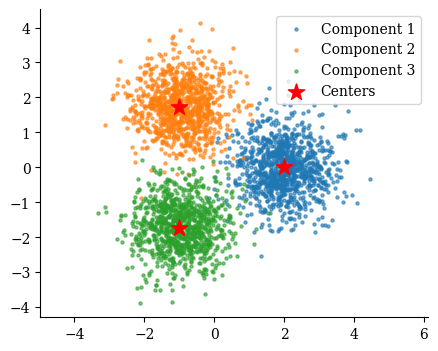

In [3]:
n_gaussian = 3
n_samples = 3000
cov = .5
radius=3

samples, labels, means, covariances, weights = load_toy_gmm(n_gaussian=n_gaussian, 
                                                            n_samples=n_samples, 
                                                            cov=cov)

plt.figure(figsize=(5, 4))
for i in range(n_gaussian):
    component_samples = samples[labels == i]
    plt.scatter(component_samples[:, 0], component_samples[:, 1], alpha=0.6, s=5, label=f"Component {i+1}")

plt.scatter(means[:, 0], means[:, 1], marker="*", s=150, c="red", label="Centers")
plt.legend()
plt.axis('equal')
plt.show()

### VAE design


In [ ]:
n_epochs = 100
device = "cpu"
lr = 0.0001
tau = 3.0
n_components = 3
hidden_dim = 64
latent_dim = 2
input_dim = 100
batch_size = 50
# beta = 1.0

global_step = 0
annealing_rate = 1e-4
min_temperature = 0.5
update_temp_every = 100

dataset = GMMDataset(n_components, 10*batch_size, 1.0, 3)
loader = DataLoader(dataset, batch_size=batch_size)




prior_variances = torch.ones(n_components, latent_dim)
prior_weights = torch.ones(n_components)/n_components
prior_means = dataset.means

n_batches = len(loader.dataset)

for beta in [0.1, 0.5, 1.0, 5.0, 1.0]:
    total_losses = []
    recon_losses = []
    mw2_losses = []
    model_gmm = SimpleVAE(input_dim=input_dim, 
                     hidden_dim=hidden_dim, 
                     latent_dim=latent_dim, 
                     n_components=n_components,
                     distribution="gmm") 
    optimizer = optim.Adam(model_gmm.parameters(), lr=lr)
    for epoch in tqdm(range(n_epochs)):
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_mw2_loss = 0
        for src_sample, proj_sample, label in loader:
            proj_sample = proj_sample.to(device)
            optimizer.zero_grad()

            # Update temperature
            if global_step % update_temp_every == 0:
                tau = max(min_temperature, torch.exp(torch.tensor(-annealing_rate * global_step)).item())

            means, variances, weights_logits, pred_latent, pred = model_gmm(proj_sample, tau)

            recon_loss = F.mse_loss(pred, proj_sample, reduction="mean")
            mw2_loss = gmm_w2_distance(means, # (batch_size, n_components, latent_dim)
                                    variances, # (batch_size, n_components, latent_dim)
                                    F.softmax(weights_logits, dim=-1), # (batch_size, n_components)
                                    prior_means, # (n_components, latent_dim)
                                    prior_variances, # (n_components, latent_dim)
                                    prior_weights) # (n_components,)
            
            loss = recon_loss + beta * mw2_loss
            loss.backward()
            epoch_total_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_mw2_loss += mw2_loss.item()
            optimizer.step()

            global_step += 1
        avg_loss = epoch_total_loss / n_batches
        avg_recon = epoch_recon_loss / n_batches
        avg_mw2 = epoch_mw2_loss / n_batches
        total_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        mw2_losses.append(avg_mw2)
    np.save(f"../results/total_losses_beta{beta}.npy", total_losses)
    np.save(f"../results/recon_losses_beta{beta}.npy", recon_losses)
    np.save(f"../results/mw2_losses_beta{beta}.npy", mw2_losses)
    torch.save(model_gmm.state_dict(), f"../results/model_gmm_beta{beta}.pt")


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


In [ ]:
beta = [0.1, 0.5, 1.0, 5.0, 1.0]
total_losses = []
recon_losses = []
mw2_losses = []
for b in beta:
    total_loss = np.load(f"../results/total_losses_beta{b}.npy")
    total_losses.append(total_loss)

    recon_loss = np.load(f"../results/recon_losses_beta{b}.npy")
    recon_losses.append(recon_loss)

    mw2_loss = np.load(f"../results/mw2_losses_beta{b}.npy")
    mw2_losses.append(mw2_loss)

total_losses = np.array(total_losses)
recon_losses = np.array(recon_losses)
mw2_losses = np.array(mw2_losses)

plt.figure()
for b, l in zip(beta, mw2_losses):
    plt.plot(l, label=rf"$\beta$={b}")
plt.legend()
# plt.savefig(os.path.join(save_path, f"mw2_losses_beta.png"), bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=300)
plt.show()

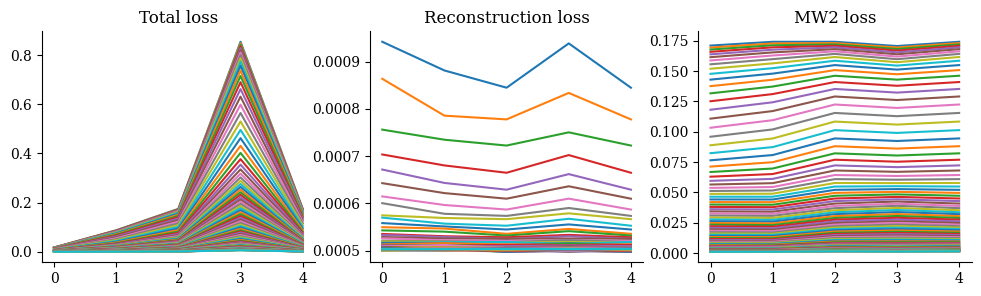

In [51]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].plot(total_losses)
ax[0].set_title("Total loss")
ax[1].plot(recon_losses)
ax[1].set_title("Reconstruction loss")
ax[2].plot(mw2_losses)
ax[2].set_title("MW2 loss")
plt.show()

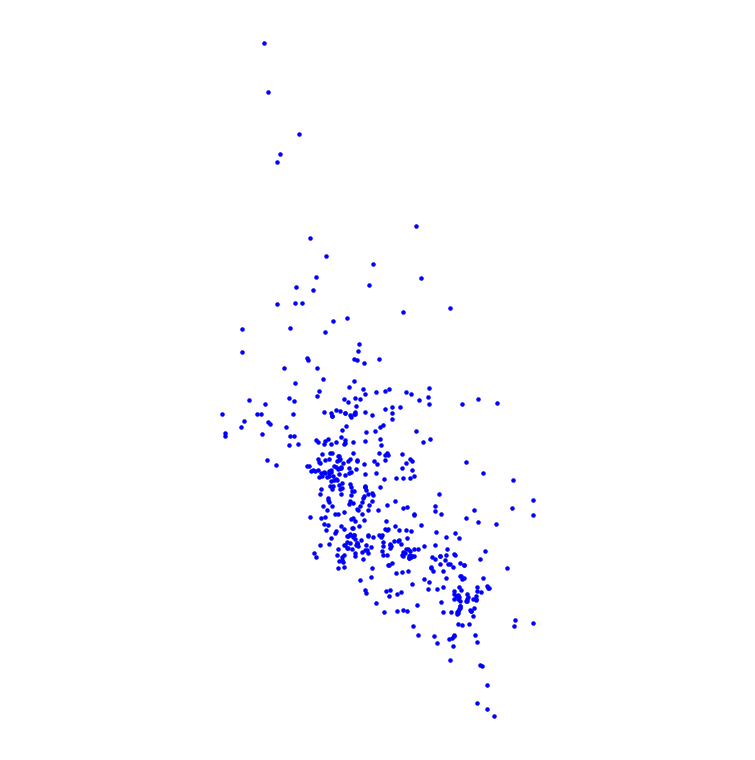

In [74]:
model_gmm = SimpleVAE(input_dim=input_dim, 
                     hidden_dim=hidden_dim, 
                     latent_dim=latent_dim, 
                     n_components=n_components,
                     distribution="gmm")
model_gmm.load_state_dict(torch.load("../results/model_gmm_beta0.1.pt"))


tau = 0.001
all_z = []
all_label = []
all_sample_gt = []
all_sample_recon = []
model_gmm.eval()
for sample_gt, sample_proj, label in loader:
    with torch.no_grad():
        means, variances, weights_logits, z, recon = model_gmm(proj_sample, tau)
        # z = model_gmm.reparameterize(means, variances, weights_logits, tau).squeeze(1)
    all_z.append(z)
    all_label.append(label)
    all_sample_gt.append(sample_gt)
    all_sample_recon.append(recon)

z_concat = torch.concatenate(all_z, dim=0)
label_concat = torch.concatenate(all_label)
sample_gt_concat = torch.concatenate(all_sample_gt, dim=0)
sample_recon_concat = torch.concatenate(all_sample_recon, dim=0)

lim=6
plt.figure(figsize=(8,8))
plt.scatter(sample_recon_concat[:, 0], sample_recon_concat[:, 1], s=5, c="blue")
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.tight_layout()
plt.axis("off")
plt.axis("equal")
# plt.savefig(os.path.join(save_path, f"initial_distribution.png"), bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=300)
plt.show()

# fig, ax = plt.subplots(1, 3, figsize=(12, 3))
# for c in range(n_components):
#     z_c = z_concat[label_concat==c]
#     sample_gt_c = sample_gt_concat[label_concat==c]
#     sample_recon_c = sample_recon_concat[label_concat==c]
#     ax[0].scatter(z_c[:, 0], z_c[:, 1], label=c, s=5)
#     ax[1].scatter(sample_gt_c[:, 0], sample_gt_c[:, 1], label=c, s=5)
#     ax[2].scatter(sample_recon_c[:, 0], sample_recon_c[:, 1], label=c, s=5)


# ax[0].set_title("latent space")
# ax[0].set_xlim(-lim,lim)
# ax[0].set_ylim(-lim,lim)
# ax[1].set_title("ground truth")
# ax[1].set_xlim(-lim,lim)
# ax[1].set_ylim(-lim,lim)
# ax[2].set_title("reconstruction")
# ax[2].set_xlim(-lim,lim)
# ax[2].set_ylim(-lim,lim)
# for a in ax:
#     a.set_aspect("equal")
#     # a.set_xticks(range(-5, 6, 1))
#     # a.set_yticks(range(-5, 6, 1))

# plt.axis("equal")
# plt.show()

In [ ]:
plt.figure()
for c in range(n_components):
    z_c = z_concat[label_concat==c]
    plt.scatter(z_c[:,0], z_c[:,1], s=5)
plt.axis("equal")
plt.show()

### Training loop for a normal vae

In [92]:
dataset = GMMDataset(n_components, 10*100, 1.0, 3)
loader = DataLoader(dataset, batch_size=100)

model_normal = SimpleVAE(input_dim=input_dim, 
                     hidden_dim=hidden_dim, 
                     latent_dim=latent_dim, 
                     n_components=n_components,
                     distribution="normal") 

optimizer = optim.Adam(model_normal.parameters(), lr=lr)

def train(model, optimizer, beta=1.0):
    epoch_loss = 0
    for src_sample, x_mb, label in loader:
            optimizer.zero_grad()
            
            _, (q_z, p_z), _, x_mb_ = model(x_mb) # [batch_size, 100]
            
            # loss_recon = nn.BCEWithLogitsLoss(reduction='none')(x_mb_, x_mb).sum(-1).mean()
            loss_recon = nn.MSELoss(reduction='none')(x_mb_, x_mb).sum(-1).mean()

            loss_KL = beta * torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()

            loss = loss_recon + loss_KL

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    return epoch_loss

for epoch in tqdm(range(n_epochs)):
    l = train(model_normal, optimizer)

100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


In [93]:
latents = []
for sample_gt, sample_proj, label in loader:
    with torch.no_grad():
        locs, scales = model_normal.encode(proj_sample)
        latents.append(locs)

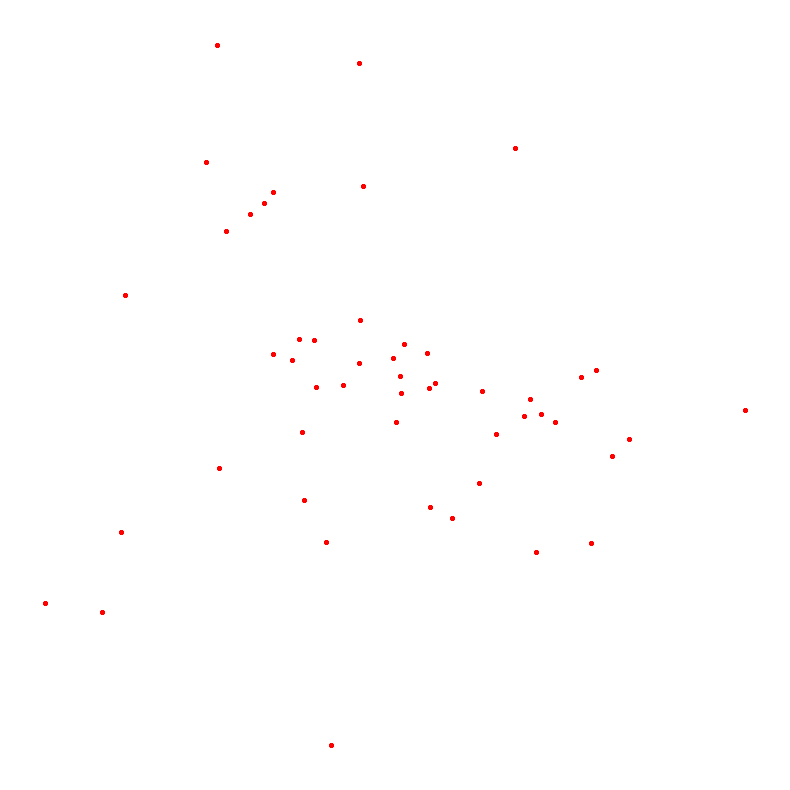

In [96]:
latents_concat = torch.concatenate(latents, dim=0)
plt.figure(figsize=(8,8))
plt.scatter(latents_concat[:,0], latents_concat[:,1], c="red", s=5)
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(save_path, f"latent_nvae.png"), bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=300)

### Experiments on Gumbel-softmax for differentiable reparametrization trick for GMMs

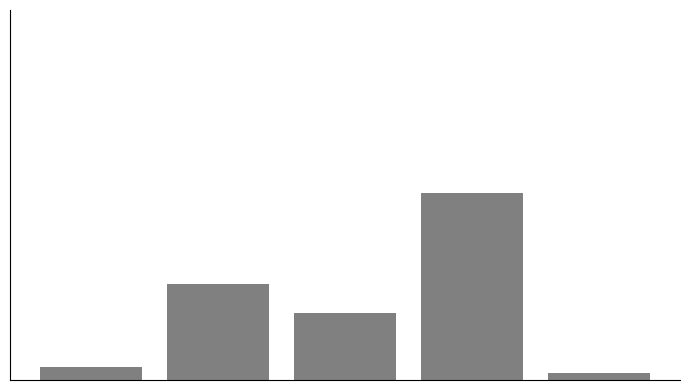

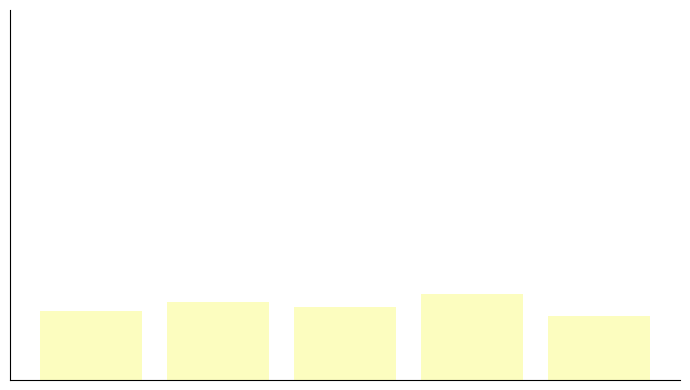

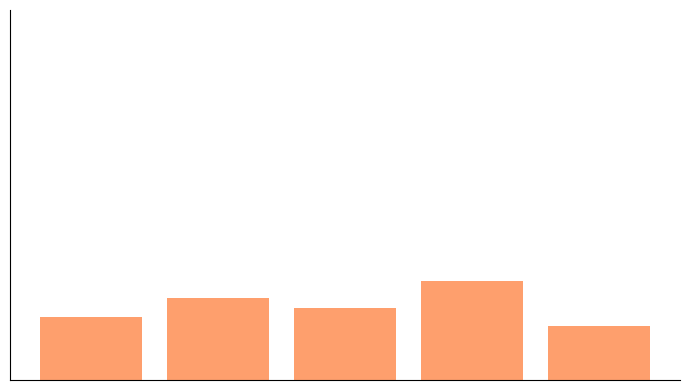

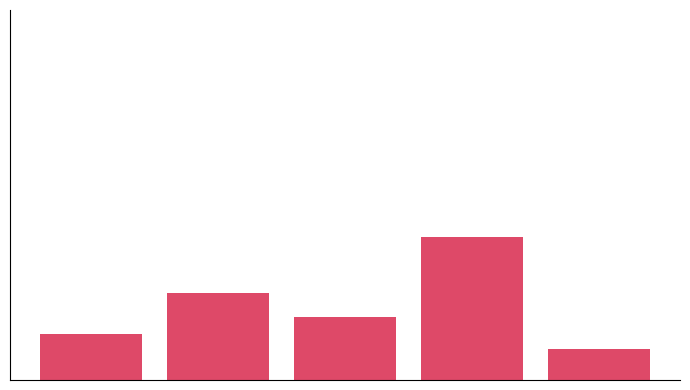

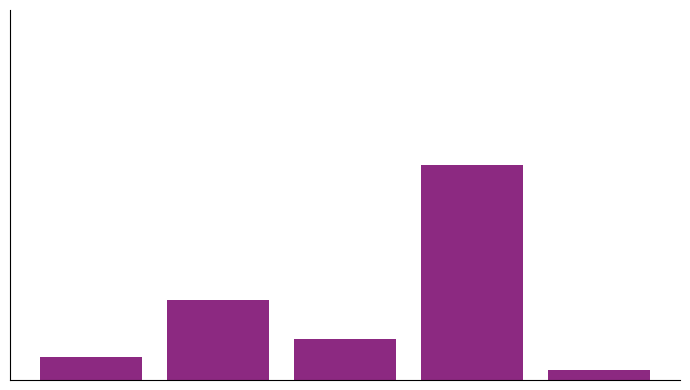

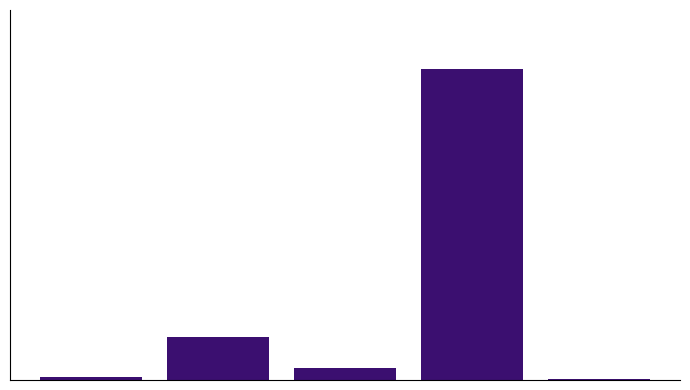

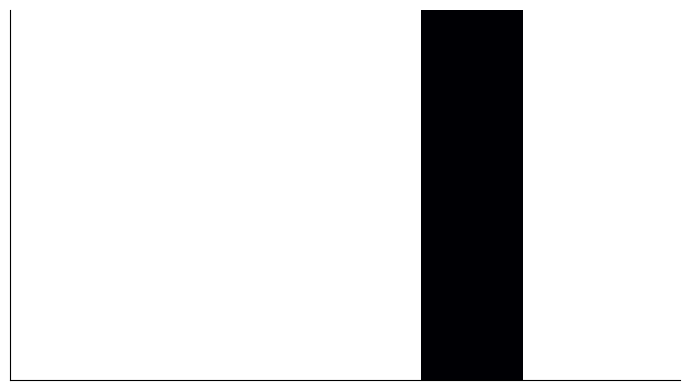

In [ ]:
batch_size=1
n_components = 5
eps = 1e-10
tau_values = [10, 5, 2, 1.0, 0.5, 0.1]

logits = 4*torch.rand(batch_size, n_components)-2 # Outputs of the encoder (simulated)
weights = F.softmax(logits, dim=1)

# Gumbel softmax
u = torch.rand_like(logits)
gumbel = -torch.log(-torch.log(u + eps))

results = {}
for tau in tau_values:
    gumbel_softmax = torch.softmax((logits + gumbel) / tau, dim=-1)
    results[tau] = gumbel_softmax.squeeze().numpy()


# ==> Plots and save
x = range(n_components)
magma = matplotlib.colormaps.get_cmap("magma")
colors = [magma(1 - i/(len(tau_values)-1)) for i in range(len(tau_values))]

# Plot initial weights
plt.figure(figsize=(7,4))
plt.bar(x, weights.squeeze(), color="gray")
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.ylim(0, 1)
plt.savefig(os.path.join(save_path, f"gumbel_weights_raw.png"), bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=300)
plt.close()

for i, (tau, gumbel_softmax) in enumerate(results.items()):
    plt.figure(figsize=(7,4))
    plt.bar(x, gumbel_softmax, color=colors[i])
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.ylim(0, 1)
    plt.tight_layout()
    # plt.savefig(os.path.join(save_path, f"gumbel_weights_tau{tau}.png"), bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=300)
    # plt.close()

### Differentiable GMM sampler following the algorithm defined in the paper

In [ ]:
class DifferentiableGMMSampler:
    
    def sample_gumbel(self, shape, eps=1e-10):
        u = torch.rand(shape)
        return -torch.log(-torch.log(u + eps) + eps)
    
    def gumbel_softmax_sample(self, logits, temperature):
        gumbel_noise = self.sample_gumbel(logits.shape)
        gumbel_logits = (logits + gumbel_noise) / temperature
        y = F.softmax(gumbel_logits, dim=-1)
        return y
    
    def sample(self, weights, means, variances, temperature=1.0, hard=False, n_samples=1):
        batch_size, n_components = weights.shape
        _, _, feature_dim = means.shape
        
        weights = F.softmax(weights, dim=-1)
        
        stds = torch.sqrt(variances)
        
        weights = weights.unsqueeze(1).expand(batch_size, n_samples, n_components)
        means = means.unsqueeze(1).expand(batch_size, n_samples, n_components, feature_dim)
        stds = stds.unsqueeze(1).expand(batch_size, n_samples, n_components, feature_dim)
        
        log_weights = torch.log(weights + 1e-10) 
        component_probs = self.gumbel_softmax_sample(log_weights, temperature) # Can also take raw logits as input

        if hard:
            indices = torch.argmax(component_probs, dim=-1)
            component_probs_hard = F.one_hot(indices, n_components).float()
            component_probs = (component_probs_hard - component_probs).detach() + component_probs
        
        epsilon = torch.randn(batch_size, n_samples, 1, feature_dim)

        component_samples = means + stds * epsilon
        
        component_probs = component_probs.unsqueeze(-1)  # (batch, samples, components, 1)
        weighted_samples = component_probs * component_samples
        
        samples = weighted_samples.sum(dim=2)  # (batch, samples, feature_dim)
        
        return samples
    
    

# Random data
batch_size = 2
n_components = 3
feature_dim = 2

weights = torch.tensor([[0.3, 0.4, 0.3], [0.5, 0.2, 0.3]])

means = torch.tensor([[[0.0, 1.0], [2.0, 3.0], [4.0, 5.0]],
                      [[6.0, 7.0], [8.0, 9.0], [10.0, 11.0]]])

variances = torch.tensor([[[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]],
                          [[0.7, 0.8], [0.9, 1.0], [1.1, 1.2]]])

sampler = DifferentiableGMMSampler()

# Soft differentiable sampling
samples_soft = sampler.sample(weights, means, variances, temperature=0.5, hard=False, n_samples=5)

# Hard sampling
samples_hard = sampler.sample(weights, means, variances, temperature=0.5, hard=True, n_samples=5)

# Check gradients flow for soft sampling
if torch.is_grad_enabled():
    weights.requires_grad_(True)
    means.requires_grad_(True)
    variances.requires_grad_(True)
    
    samples = sampler.sample(weights, means, variances, temperature=0.5, hard=False)
    loss = samples.sum()
    loss.backward()
    
    print("Gradients flowing through weights:", weights.grad is not None)
    print("Gradients flowing through means:", means.grad is not None)
    print("Gradients flowing through variances:", variances.grad is not None)

Gradients flowing through weights: True
Gradients flowing through means: True
Gradients flowing through variances: True


### Generate samples

In [ ]:
n_gaussian = 3
n_samples = 3000
cov = 1.0
radius = 3
tau_values = [10, 2, 1.0, 0.5, 0.1]

theta = torch.linspace(0, 2 * torch.pi * (n_gaussian-1)/n_gaussian, n_gaussian)
x = radius * torch.cos(theta)
y = radius * torch.sin(theta)
means = torch.column_stack((x, y)).unsqueeze(0)
variances = cov * torch.ones(n_gaussian, 2).unsqueeze(0)
weights = (torch.ones(n_gaussian) / n_gaussian).unsqueeze(0)

for tau in tau_values:
    samples = sampler.sample(weights, 
                             means, 
                             variances, 
                             temperature=tau, 
                             hard=False, 
                             n_samples=n_samples).squeeze(0)

    plt.figure(figsize=(8,8))
    plt.scatter(samples[:,0], samples[:,1], s=5, alpha=.6, c="orange")
    plt.scatter(means.squeeze(0)[:,0], means.squeeze(0)[:,1], marker="+", s=150, c="red")
    plt.axis("off")
    plt.axis("equal")
    plt.tight_layout()
    # plt.savefig(os.path.join(save_path, f"differentiable_sampling{tau}.png"), bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=300)
    # plt.close()